# Make Structured 3D Mesh

A common input into 3D inversions is a structured mesh with equal cells within the station area and some padding cells.  There are some tools in MTpy that can help design a mesh based on station locations, add topography or bathymetry, write to file specific for the inversion code.  

In [1]:
%matplotlib widget

In [41]:
from pathlib import Path
from mtpy import MTData
from mtpy.modeling import StructuredGrid3D

## 1. Read Data File

In the previous notebook we created a data file, lets read that in and use the station locations to create a structured mesh for finite element codes like ModEM, WS3DINV, JIF3D.

In [4]:
mtd = MTData()
mtd.from_modem_data(r"example_modem_data_file.dat")

## 2. Create a Model

Now that we have station locations we can create a 3D mesh.

In [8]:
mesh = StructuredGrid3D()
mesh.station_locations = mtd.station_locations
mesh.center_point = mtd.center_point

### Horizontal Set Cell Sizes

We can set the lateral cell sizes in the east and north direction.  There is a trade-off between cell size, computation speed, and resolution.  Ideally you would like a few cells between each station to allow the inversion to find a better solution, but you don't want too many that it will take ages to calculate.  

The example data was collected at about 8 km station spacing, so lets try 2km cell sizes within the station area.

In [11]:
mesh.cell_size_east = 2000
mesh.cell_size_north = 2000

#### Horizontal Padding cells

There are a few different padding cells.  

- `pad_num` is the number of padding cells of the same size as the station cells that extent outside the station area (default is 3)
- `pad_east` and `pad_north` describe the number of padding cells between the edge of the station area and the desired extent, these are calculated on an exponential distance.  

In [12]:
mesh.pad_east = 10
mesh.pad_north = 10

In [17]:
mesh.ew_ext = 250000
mesh.ns_ext = 250000

#### Vertical Cells

Because MT is a diffusive method we want to have a vertical grid that increases in size as a function of depth.  There are a few ways to do this.  Here we provide the first layer thickness `z1_layer`, the number of layers `n_layers` and the target depth `z_target_depth`.  Then the cells will increase geometrically from the `z1_layer` to `z_target_depth`.  These data are meant to image regional structures using broadband data, so the first layer should be thin and target depth around 50 km.

In [13]:
mesh.z1_layer = 10
mesh.n_layers = 50
mesh.z_target_depth = 50000

#### Vertical Padding cells

We also need some padding cells in the vertical direction. We can set the geometric factor if needed.

In [14]:
mesh.pad_z = 5
mesh.pad_stretch_v = 1.5

### Make Mesh 

Now we can create the mesh and see what it looks like.

In [18]:
mesh.make_mesh()

ModEM Model Object:
--------------------
	Number of stations = 59
	Mesh Parameter: 
		cell_size_east:    2000
		cell_size_north:   2000
		pad_east:          10
		pad_north:         10
		pad_num:           3
		z1_layer:          10
		z_target_depth:    50000
		n_layers:          50
		res_initial_value: 100.0
	Dimensions: 
		e-w: 61
		n-s: 62
		z:   51 (without 7 air layers)
	Extensions: 
		e-w:  252000.0 (m)
		n-s:  250000.0 (m)
		0-z:  186682.0 (m)
--------------------


<div class="alert alert-block alert-info">
    <b>Note:</b> in the plot below the station locations in the vertical profile show elevation, this is only if you want elevation included, it can be ignored for now. We will add topography later and project the stations properly.
</div>

2023-04-19 16:13:16,783 [line 45] mtpy.modeling.plots.plot_mesh.PlotMesh._plot_topography - WARNING: Cannot find topography information, skipping


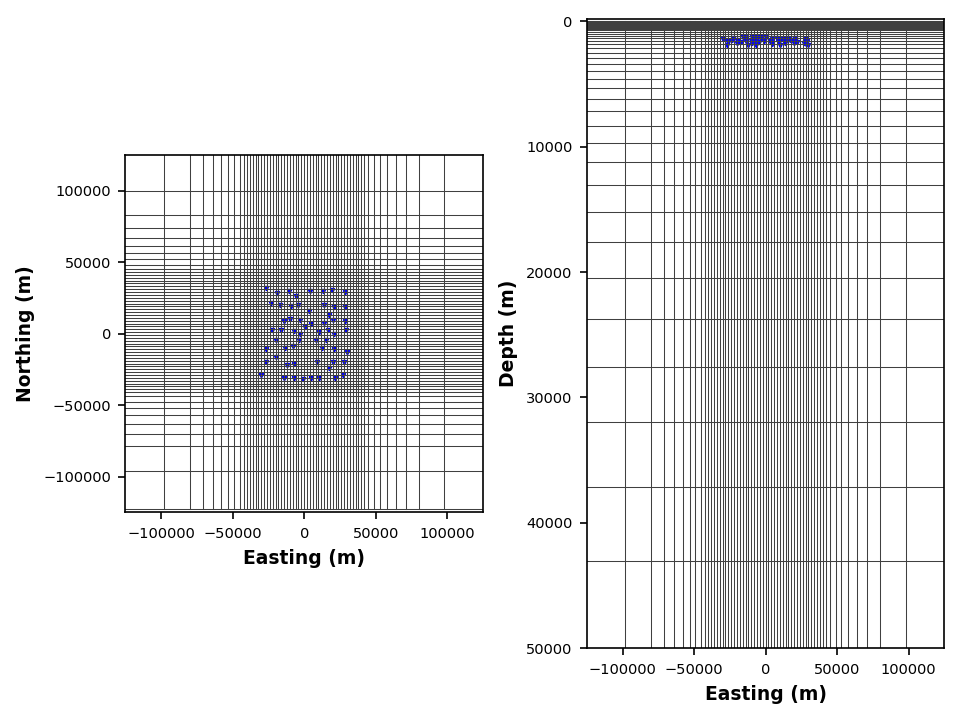

In [22]:
plot_mesh = mesh.plot_mesh(x_limits=(-mesh.ew_ext/2, mesh.ew_ext/2), y_limits=(-mesh.ns_ext/2, mesh.ns_ext/2))

## 3. Add Topography

In some cases its important to model topography.  You can download a DEM and convert it to an ESRI ASCII file (unfortunately this is what is supported at the moment, hoping to expand). Or you can use the data elevations for a crude estimation of the elevation. 

You need to add some air cells to the model to include topograpy. If you do not then only bathymetry is projected onto the mesh, which is useful for areas near the coast.

`airlayer_type` identifies the method to add topography cells to the model

  - `log_down` places the top of the model at the top of the topography then increases cell sizes downwards and resets the mesh.
  - `log_up` added topography cells with increasing sizes upwards from sea level.
  - `constant` adds equal thickness cells from the top of topography to mean elevation within the station area. (can be computationally expensive if there's a lot of topography.
  
`max_elev` can be set to the maximum topography height in the model, which can be useful if there are large mountains between stations that don't need to be modeled.  

In [29]:
mesh.n_air_layers = 30

In [34]:
mesh.add_topography_to_model(r"c:\Users\jpeacock\OneDrive - DOI\ArcGIS\westcoast_etopo.asc", airlayer_type="log_down")

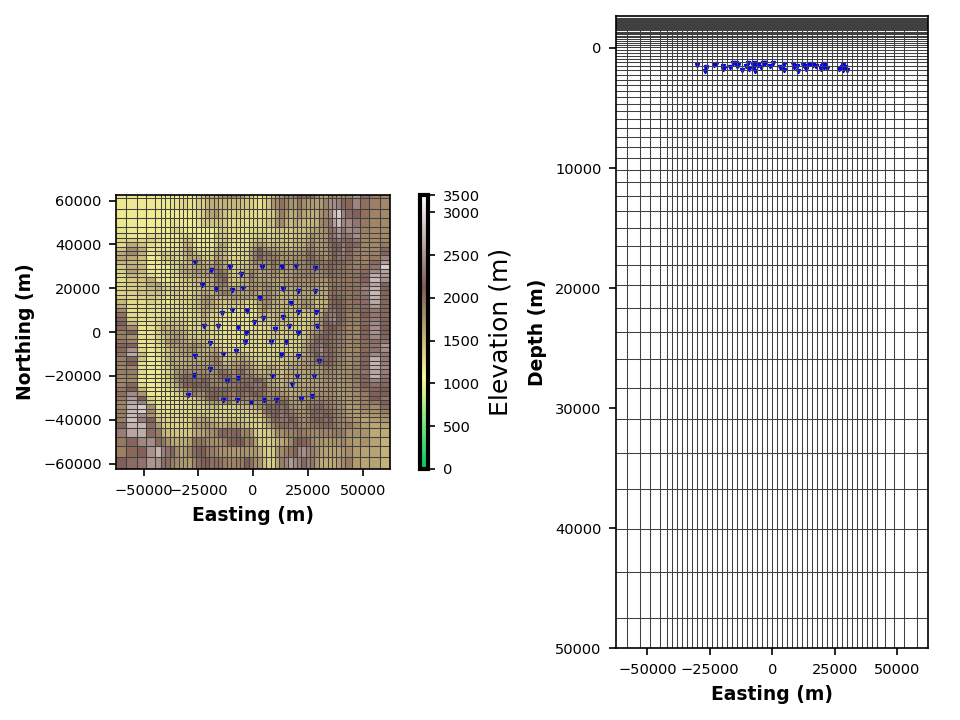

In [39]:
plot_topography = mesh.plot_mesh(fig_num=5, x_limits=(-mesh.ew_ext/4, mesh.ew_ext/4), y_limits=(-mesh.ns_ext/4, mesh.ns_ext/4))

In [28]:
mesh

ModEM Model Object:
--------------------
	Number of stations = 59
	Mesh Parameter: 
		cell_size_east:    2000
		cell_size_north:   2000
		pad_east:          10
		pad_north:         10
		pad_num:           3
		z1_layer:          10
		z_target_depth:    50000
		n_layers:          50
		res_initial_value: 100.0
	Dimensions: 
		e-w: 61
		n-s: 62
		z:   81 (without 7 air layers)
	Extensions: 
		e-w:  252000.0 (m)
		n-s:  250000.0 (m)
		0-z:  126566.0 (m)
--------------------

## 5. Write to File
Now write to a file.  This will be in ModEM style.

In [42]:
mesh.write_model_file(save_path=Path().cwd())

2023-04-19T16:27:45 [line 910] StructuredGrid3D.write_model_file - INFO: Wrote file to: C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\examples\notebooks\ModEM_Model_File.rho


## 6. Write Covariance File

Now that topography is in the model, we need to freeze air cells in the covariance matrix to avoid computational issues.   

In [43]:
from mtpy.modeling.modem import Covariance

In [44]:
cov = Covariance()
cov.write_covariance_file(model_fn=mesh.model_fn)

2023-04-19T16:29:18 [line 215] Covariance.write_covariance_file - INFO: Wrote covariance file to C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\examples\notebooks\covariance.cov
